### Содержание

1. [Импорты и загрузки](#section1)
2. [Предобработка и нормализация](#section2)
3. [Работа с очищенными данными](#section3)
4. [Bag-of-words модель](#section4)
5. [RuBert Tiny 2 + FC](#section5)
6. [KNNClassifier](#section6)
7. [Итог](#section7)

### Импорты и загрузки
<a id = 'section1'></a>

In [1]:
import pickle
import itertools
import torch
import pandas as pd
import numpy as np
import nltk
import swifter # нужен для ускорения работы pandas
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sentence_transformers import SentenceTransformer
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from utils.ctfidf import CTFIDFVectorizer
from utils.datasets import TextDataset, RuBertDataset
from utils.models import BagOfWordsModel, RuBertClassifier
from utils.utils import preprocess_text, train_model, test_model

tqdm.pandas() # нужно для работы progress bar'ов

In [3]:
ARTEFACTS_PATH = './artefacts'
DATASET_PATH = './dataset'
SKLEARN_MODELS_PATH = './sclearn_saved_models'
TORCH_MODELS_PATH = './models'

N_CLASSES = 47

# зададим random state
torch.manual_seed(42)

# загрузка всего необходимого
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/alex-utk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alex-
[nltk_data]     utk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Предобработка и нормализация
<a id = 'section2'></a>

In [ ]:
# почистим и нормализуем данные
data = pd.read_csv(f'{DATASET_PATH}/train.csv', sep=',')
data = data.drop(columns=['id'])
data['text'] = data['text'].swifter.apply(preprocess_text) # apply с прикрученым tqdm
data.to_csv(f'{DATASET_PATH}/train_preprocessed.csv', index=False)

In [13]:
# загрузка нормализованных данных
data = pd.read_csv(f'{DATASET_PATH}/train_preprocessed.csv', sep=',')
print(len(data))
data.head()

105950


,text,label
0,девятнадцатый арбитражный апелляционный суд по...,20
1,двадцатый арбитражный апелляционный суд постан...,12
2,шестой арбитражный апелляционный суд постановл...,7
3,восемнадцатый арбитражный апелляционный суд по...,23
4,седьмой арбитражный апелляционный суд постанов...,17


Используя сtf-idf (поклассовый tf-idf), выясним, какие слова наиболее часто встречаются в документах с соответствующими классами, возмем топ 10.


Также выясним, топ 5000 слов с конца, которые являются бесполезными для нашей задачи классификации. Как правило это слова с ошибками, опечатками и просто ненужные нам (фамилии, бесполезный контекст и т.д.)

In [ ]:
# для начала сгруппируем тексты по метке класса
# лучше не запускать эту ячейку, так как ест очень много памяти
# тут мы используем кастомный CTF-IDF класс
data_grouped = data.groupby(['label'], as_index=False).agg({'text': ' '.join})

count_vectorizer = CountVectorizer().fit(data_grouped['text'])
count = count_vectorizer.transform(data_grouped['text'])

ctfidf = CTFIDFVectorizer()
ctfidf.fit(count, n_samples=105950) # 105950 - это размер трейновой выборки, захардкодил из-за ограничений памяти
matrix = ctfidf.transform(count)

# сохраним как артефакт, так как считается долго
pickle.dump(ctfidf, open('sclearn_saved_models/ctfidf.pkl', 'wb'))
pickle.dump(matrix, open('sclearn_saved_models/matrix.pkl', 'wb'))

In [8]:
# загрузим данные
ctfidf = pickle.load(open('sclearn_saved_models/ctfidf.pkl', 'rb'))
matrix = pickle.load(open('sclearn_saved_models/matrix.pkl', 'rb'))

all_words = count_vectorizer.get_feature_names_out()
print(matrix.shape)
print(all_words.shape)

(47, 209602)
(209602,)


In [ ]:
# сохраним топ 10 самых важных по tf-idf слов в классе
top_n = 50 
labels = list(range(47))
words_per_class = {label: all_words[matrix[label].toarray().argsort()[0,-top_n:]] for label in labels}
with open(f'{ARTEFACTS_PATH}/best_{top_n}.txt', 'wt') as file:
    for label, words in words_per_class.items():
        file.write(f'{label}\t{", ".join(words)}\n')
       
# сделаем тоже самое для топ 5000 самых мусорных слов
worst_n = 5000
words_per_class = {label: all_words[matrix[label].toarray().argsort()[0,:worst_n]] for label in labels}
with open(f'{ARTEFACTS_PATH}/worst_{worst_n}.txt', 'wt') as file:
    for label, words in words_per_class.items():
        file.write(f'{label}\t{", ".join(words)}\n')

custom_stop_words = [words for _, words in words_per_class.items()]
custom_stop_words = list(set(itertools.chain(*custom_stop_words)))

pickle.dump(custom_stop_words, open(f'{ARTEFACTS_PATH}/custom_stop_words.pkl', 'wb'))
print(f'Размер словаря бесполезных слов: {len(custom_stop_words)}')

# таким образом можно почистить мусорные слова, полученные в результате ошибок/опечаток и просто ненужные нам,
# но которые в норме не являются стоп словами

In [2]:
# почистим данные еще раз
# не запускать, ячейка очень долго работает, ~7 часов
custom_stop_words = pickle.load(open(f'{ARTEFACTS_PATH}/custom_stop_words.pkl', 'rb'))
data = pd.read_csv(f'{DATASET_PATH}/train_preprocessed.csv', sep=',')

def filter_stop_words(text):
    tokens = text.split()
    tokens = list(filter(lambda token: token not in custom_stop_words,
                          tokens))
    return ' '.join(tokens)
data['text'] = data['text'].swifter.apply(filter_stop_words)
data.to_csv(f'{DATASET_PATH}/train_no_stop_words.csv', index=False)

Теперь проведем чистку тестовых данных аналогичным образом

In [12]:
# почистим и нормализуем данные
test_data = pd.read_csv(f'{DATASET_PATH}/test.csv', sep=',')
test_data = test_data.drop(columns=['id'])
test_data['text'] = test_data['text'].swifter.apply(preprocess_text) # apply с прикрученым tqdm
test_data.to_csv(f'{DATASET_PATH}/test_preprocessed.csv', index=False)

Pandas Apply:   0%|          | 0/1952 [00:00<?, ?it/s]

### Работа с очищенными данными
<a id = 'section3'></a>

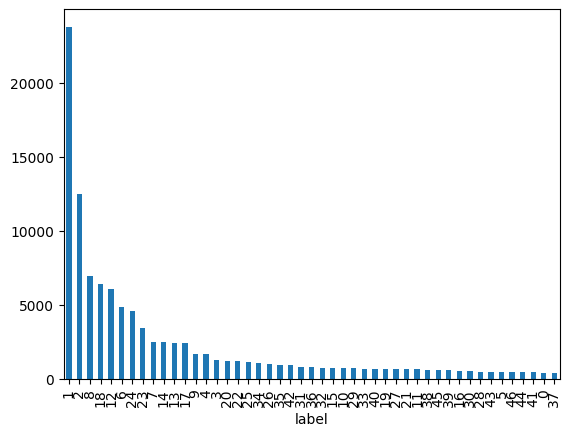

In [3]:
# заметен очень сильный дизбаланс классов
# micro prescision-recall может дать не самую точную метрику,
# так как точность будет оцениваться в основном по самым частотным классам, более редкие
# фактически будут иметь меньший вес
train_data = pd.read_csv('train_no_stop_words.csv')
train_data.loc[:, 'label'].value_counts().plot(kind='bar');

### Bag-of-Words модель
<a id = 'section4'></a>

Попробуем простую модель с bag-of-words подходом и несколькими полносвязаными слоями.

Закодируем тестовую и трейн выборку при помощи CountVectorizer и полученные вектора будем использовать для обучения классификатора.

In [ ]:
# еще один, гораздо более быстрый способ фильтрации мусорных слов - задать min_df порог,
# отсеивающий слишком редкие и бесполезные слова
# размер словаря: был - 187615, стал - 14755
train_data = pd.read_csv('train_no_stop_words.csv')

vectorizer = CountVectorizer(min_df=0.0003) # наиболее оптимальный порог
vectorizer.fit(train_data['text'])
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

train_data['text'] = train_data['text'].progress_apply(lambda text: vectorizer.transform([text]))
train_data = train_data.rename(columns={'text': 'features'})
train_data.to_pickle(f"{DATASET_PATH}/train_data_encoded.pkl")

# посмотрим на слова, которые у нас сохранились и
# будут использоваться для кодирования
lst = list(vectorizer.get_feature_names_out())
with open(f'{ARTEFACTS_PATH}/final_dict.txt', 'wt') as file:
    for word in lst:
        file.write(f'{word}\n')

In [4]:
vectorizer = pickle.load(open(f'{SKLEARN_MODELS_PATH}/vectorizer.pkl', 'rb'))
data = pd.read_pickle(f'{DATASET_PATH}/train_data_encoded.pkl')

# Разбиение на трейн и валидацию
train_set, val_set = train_test_split(data, test_size=0.1, random_state=42,
                                      stratify=data['label']) # обязательно стратификацию

train_data = TextDataset(train_set)
val_data = TextDataset(val_set)

train_loader = DataLoader(train_data, batch_size=23838, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_data, batch_size=10595, shuffle=True, num_workers=0, drop_last=True)


model = BagOfWordsModel(embed_dim=len(vectorizer.get_feature_names_out()), # 14755
                        num_class=N_CLASSES) 
model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

In [5]:
type(criterion)

torch.nn.modules.loss.CrossEntropyLoss

In [ ]:
n_epochs = 1000
train_model(model, train_loader, val_loader, criterion, sheduler,
            optimizer, n_epochs, f'{TORCH_MODELS_PATH}/BagOfWords.pt')

In [4]:
# загрузка обученной модели
model.load_state_dict(torch.load(f'{TORCH_MODELS_PATH}/BagOfWords.pt'))
model.eval()
model.cuda()

BagOfWordsModel(
  (fc1): Linear(in_features=14755, out_features=300, bias=True)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=100, out_features=47, bias=True)
)

In [5]:
# Подготовка тестовой части
test_data = pd.read_csv(f'{DATASET_PATH}/test_preprocessed.csv')

vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))

test_data['text'] = test_data['text'].progress_apply(lambda text: vectorizer.transform([text]))
test_data = test_data.rename(columns={'text': 'features'})

test_dataset = TextDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=14)

100%|██████████| 1952/1952 [00:01<00:00, 1130.89it/s]


In [7]:
# Оценка метрик
precision, recall = test_model(model, test_loader, n_classes=47)
print(f'Точность - {precision}') 
print(f'Полнота - {recall}')


Точность - 0.7694672346115112
Полнота - 0.7694672346115112


### RuBert Tiny 2 + FC
<a id = 'section5'></a>

В данном подходе попробуем использовать дистиллированый [rubert-tiny-2](https://huggingface.co/cointegrated/rubert-tiny2).

Будем получать эмбеддинги всего текста и использовать их с полносвязным слоем для получения класса.

В ходе эскпериментов понял, что больше одного слоя делать не очень, так как лосс очень плохо сходится.

In [27]:
# в качестве энкодера текстов используем rubert-tiny2
# будем кодировать текст в вектор и пытаться с помощю одного fc слоя прдетсказывать класс

encoder = SentenceTransformer('cointegrated/rubert-tiny2')
encoder.cuda()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 2048, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 312, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [7]:
# переведем тексты в эмбеддинги и сохраним
# ячейка долго выполняется!

tqdm.pandas()
train_data = pd.read_csv(f'{DATASET_PATH}/train_no_stop_words.csv')
train_data['text'] = train_data['text'].progress_apply(lambda text: encoder.encode(text))
train_data = train_data.rename(columns={'text': 'features'})
train_data.to_pickle(f"{DATASET_PATH}/train_data_rubert.pkl")

100%|██████████| 105950/105950 [1:29:43<00:00, 19.68it/s]


In [3]:
# обучим нашу сетку правильно классифицировать тексты по эмбеддингам rubert размерности 312
data = pd.read_pickle(f"{DATASET_PATH}/train_data_rubert.pkl")

train_set, val_set = train_test_split(data, test_size=0.1, random_state=42,
                                      stratify=data['label']) # обязательно стратификацию

train_data = RuBertDataset(train_set)
val_data = RuBertDataset(val_set)

train_loader = DataLoader(train_data, batch_size=95355, shuffle=True, num_workers=10, drop_last=True)
val_loader = DataLoader(val_data, batch_size=10595, shuffle=True, num_workers=10, drop_last=True)


model = RuBertClassifier(embed_dim=312, # выход rubert-2-tiny
                         num_class=N_CLASSES)
model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

n_epochs = 10000
train_model(model, train_loader, val_loader, criterion, sheduler, optimizer,
            n_epochs, f'{TORCH_MODELS_PATH}/RuBertClassifier.pt')

In [29]:
# Подготовка тестовой части
test_data = pd.read_csv(f'{DATASET_PATH}/test_preprocessed.csv')

test_data['text'] = test_data['text'].progress_apply(lambda text: encoder.encode(text))
test_data = test_data.rename(columns={'text': 'features'})
test_data.to_pickle(f"{DATASET_PATH}/test_data_rubert.pkl")

100%|██████████| 1952/1952 [01:42<00:00, 19.02it/s]


In [30]:
# загрузка уже обученной модели
model = RuBertClassifier(embed_dim=312, # выход rubert-2-tiny
                         num_class=N_CLASSES)
model.load_state_dict(torch.load(f'{TORCH_MODELS_PATH}/RuBertClassifier.pt'))
model.eval()
model.cuda()

RuBertClassifier(
  (fc1): Linear(in_features=312, out_features=47, bias=True)
)

In [31]:
# Оценка метрик
test_data = pd.read_pickle(f"{DATASET_PATH}/test_data_rubert.pkl")
test_dataset = RuBertDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

precision, recall = test_model(model, test_loader, n_classes=N_CLASSES)
print(f'Точность - {precision}') 
print(f'Полнота - {recall}') 

Точность - 0.655225396156311
Полнота - 0.655225396156311


### KNNClassifier
<a id = 'section6'></a>

Попробуем обучиться простой KNN классификатор на эмбеддингах из ru-bert

In [3]:
train_data = pd.read_pickle(f"{DATASET_PATH}/train_data_rubert.pkl")
train_x, train_y = np.stack(train_data['features']), train_data['label']

test_data = pd.read_pickle(f"{DATASET_PATH}/test_data_rubert.pkl")
test_x, test_y = np.stack(test_data['features']), test_data['label']

In [13]:
# определим наиболее оптимальные параметры и посмотрим их
params = { 
    'n_neighbors': np.arange(15, 23, dtype=int),
    'p': [1, 2, np.inf], # манхеттенская, евклидова метрика и расстояние чёбышева
    'weights': ['uniform', 'distance'] 
}

scoring = ['precision_micro', 'recall_micro']

knn = KNeighborsClassifier()
grid_search = GridSearchCV(KNeighborsClassifier(), params,
                           scoring=scoring, refit='precision_micro', n_jobs=12)
grid_search.fit(train_x, train_y)
grid_search.best_params_

{'n_neighbors': 17, 'weights': 'distance'}

In [17]:
# теперь возмем полученные параметры и обучим на них классификатор
# учится быстро
knn = KNeighborsClassifier(n_neighbors=20, p=2,
                           n_jobs=-1, weights='distance')
knn.fit(train_x, train_y)
pred_y = knn.predict(test_x)

print(f'Точность - {precision_score(test_y, pred_y, average="micro")}') 
print(f'Полнота - {recall_score(test_y, pred_y, average="micro")}')

# Точность - 0.6480532786885246
# Полнота - 0.6480532786885246

Точность - 0.6480532786885246
Полнота - 0.6480532786885246


### Итог
<a id = 'section7'></a>

|                     | Точность           | Полнота            |
|---------------------|--------------------|--------------------|
| Bag-of-words модель | 0.7694672346115112 | 0.7694672346115112 |
| RuBert Tiny 2 + FC  | 0.6552253961563110 | 0.6552253961563110 |
| KNNClassifier       | 0.6480532786885246 | 0.6480532786885246 |

По итогу вышло, что наиболее простой подход с bag-of-words выдал лучший скор. Возможно, что использование более мощного энкодера вместо самого маленького RuBert дало бы результат лучше, но не хватило вычислительных мощностей.

В дальнейшей работе наилучшу модель имеет смысл конвертировать в onnx и заинференсить в Nvidia Triton Inference Server для более быстрой работы и поддержки динамического батчинга.